# Import Statements

In [425]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# Import Snowflake modules
from snowflake.snowpark import Session
from pyspark.sql.functions import year
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# DATA PREPARATION
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from feature_engine.outliers import Winsorizer

# MODEL BUILDING
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn. ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# MODEL EVALUATION & IMPROVEMENT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# to export model
import joblib

# Functions

In [426]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [427]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [428]:
# retrieve order details usa table from snowflake
order_detail = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_DETAIL")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")
location_table = session.table("frostbyte_tasty_bytes.raw_pos.LOCATION")

In [429]:
location_table.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                                          |"CITY"      |"REGION"                               |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1001           |222-222@4hf-nch-k2k  |Seasoners Fine Foods                                |Manchester  |Greater Manchester                     |GB                  |England    |
|1002           |222-222@4hf-ndn-4sq  |HM Music Promotions                                 |Manchester  |Greater Manchester                     |GB                  |England    |
|1003           |222-222@4hf-ndp-grk  |G J Hull                                            |Manchester  |

### Filter rows for United States ONLY

In [430]:
# Get a list of LOCATION_IDs where the COUNTRY column's value is 'United States'
## Filter the 'location_table' where the 'COUNTRY' column is 'United States'
filtered_location_table = location_table.filter(location_table['COUNTRY'] == 'United States')

## Select the 'LOCATION_ID' column from the filtered DataFrame
location_id_df = filtered_location_table.select('LOCATION_ID')

## Convert the 'LOCATION_ID' column to a Python list
location_id_list = location_id_df.collect()

## Extract the values from the DataFrame and convert them to a list
location_id_list = [row['LOCATION_ID'] for row in location_id_list]

In [431]:
order_detail.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_DETAIL_ID"  |"ORDER_ID"  |"MENU_ITEM_ID"  |"DISCOUNT_ID"  |"LINE_NUMBER"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------
|73015891           |26977276    |82              |NULL           |0              |1           |15.0000       |15.0000  |NULL                          |
|73015895           |26977277    |86              |NULL           |3              |1           |3.0000        |3.0000   |NULL                          |
|73015894           |26977277    |83              |NULL           |2              |1           |9.0000        |9.0000   |NULL                          |
|73015892           |26977277    |81              |NULL           |0              

In [432]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [433]:
# Merge the two tables using the 'ORDER_ID' column as the common key
merged_df = order_detail.join(order_header, on='ORDER_ID', how='inner')

In [434]:
# Get rows where the LOCATION_ID is for United States
merged_df = merged_df.filter(F.col('LOCATION_ID').isin(location_id_list))

In [435]:
# Filter table for only the required columns
order_df = merged_df.select("MENU_ITEM_ID", "QUANTITY", "ORDER_TS")

In [436]:
order_df.show()

-----------------------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"ORDER_TS"           |
-----------------------------------------------------
|18              |1           |2022-03-29 08:10:05  |
|17              |2           |2022-03-29 08:10:05  |
|16              |1           |2022-03-29 08:10:05  |
|12              |1           |2022-03-29 08:10:05  |
|10              |1           |2022-03-29 08:10:05  |
|12              |1           |2022-03-29 08:34:54  |
|13              |2           |2022-03-29 08:34:54  |
|15              |2           |2022-03-29 08:34:54  |
|16              |1           |2022-03-29 08:34:54  |
|17              |1           |2022-03-29 08:34:54  |
-----------------------------------------------------



### Feature Engineering: ORDER_TS to get YEAR

In [437]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_df = order_df.withColumn('ORDER_TS', F.to_timestamp(order_df['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_df = order_df.withColumn('YEAR', F.year(order_df['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_df = order_df.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_df.show()

----------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"YEAR"  |
----------------------------------------
|18              |1           |2022    |
|17              |2           |2022    |
|16              |1           |2022    |
|12              |1           |2022    |
|10              |1           |2022    |
|12              |1           |2022    |
|13              |2           |2022    |
|15              |2           |2022    |
|16              |1           |2022    |
|17              |1           |2022    |
----------------------------------------



In [438]:
# Group by 'YEAR' and 'MENU_ITEM_ID' and calculate the sum of 'QUANTITY'
total_qty_by_item = order_df.group_by(['YEAR', 'MENU_ITEM_ID']) \
                           .agg(F.sum(order_df['QUANTITY']).alias('TOTAL_QTY_SOLD_PER_YEAR')) \
                           .orderBy(['YEAR', 'MENU_ITEM_ID'])

# View the data
total_qty_by_item.show()

-------------------------------------------------------
|"YEAR"  |"MENU_ITEM_ID"  |"TOTAL_QTY_SOLD_PER_YEAR"  |
-------------------------------------------------------
|2019    |10              |5305                       |
|2019    |11              |15597                      |
|2019    |12              |15612                      |
|2019    |13              |15641                      |
|2019    |14              |5211                       |
|2019    |15              |5211                       |
|2019    |16              |5349                       |
|2019    |17              |15560                      |
|2019    |18              |15759                      |
|2019    |19              |15658                      |
-------------------------------------------------------



In [439]:
order_df_grp_by = total_qty_by_item.to_pandas()

### Account for missing Dec 2022 quantity sold for all menu items

In [440]:
# result before adding the assumed missing Dec 2022 qty sold for all items
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,149318
229,2022,11,443405
230,2022,12,441775
231,2022,13,441694
232,2022,14,149397


In [441]:
order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] = np.where(
    order_df_grp_by["YEAR"] == 2022,
    np.ceil((order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"] / 11) * 12),
    order_df_grp_by["TOTAL_QTY_SOLD_PER_YEAR"]
)

In [442]:
order_df_grp_by[order_df_grp_by["YEAR"]==2022].head()

,YEAR,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_YEAR
228,2022,10,162893.0
229,2022,11,483715.0
230,2022,12,481937.0
231,2022,13,481848.0
232,2022,14,162979.0


In [443]:
order_df_grp_by.to_csv('C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/datasets/total_qty_by_item.csv', index=False)

# Menu Table 

In [444]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [445]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [446]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, order_df_grp_by, on='MENU_ITEM_ID')

In [447]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,YEAR,TOTAL_QTY_SOLD_PER_YEAR
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,5305.0
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2020,26284.0
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2021,159322.0
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,162893.0
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,15597.0


### Feature Engineering: MENU_ITEM_HEALTH_METRICS_OBJ 

In [448]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [449]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,162893.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


# Final Table

In [450]:
final_df = menu_df

In [451]:
final_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,5305.0,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,26284.0,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,159322.0,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,162893.0,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,15597.0,1,1,0,1


In [452]:
# convert target to int type
final_df['TOTAL_QTY_SOLD_PER_YEAR'] = final_df['TOTAL_QTY_SOLD_PER_YEAR'].astype(int)

In [453]:
final_df = final_df.drop(["COST_OF_GOODS_USD", "MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME", "TRUCK_BRAND_NAME"], axis=1)
final_df.head()

,MENU_TYPE,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,10,Beverage,Cold Option,3.5,2019,5305,1,1,0,1
1,Ice Cream,10,Beverage,Cold Option,3.5,2020,26284,1,1,0,1
2,Ice Cream,10,Beverage,Cold Option,3.5,2021,159322,1,1,0,1
3,Ice Cream,10,Beverage,Cold Option,3.5,2022,162893,1,1,0,1
4,Ice Cream,11,Dessert,Cold Option,6.0,2019,15597,1,1,0,1


### Ordinal Encoding for ITEM_SUBCATEGORY

In [454]:
# Define the mapping dictionary
temperature_mapping = {'Cold Option': 0, 'Warm Option': 1, 'Hot Option': 2}

# Apply the mapping to the 'ITEM_SUBCATEGORY' column in final_df
final_df['ITEM_SUBCATEGORY'] = final_df['ITEM_SUBCATEGORY'].map(temperature_mapping)

final_df.head()

,MENU_TYPE,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,10,Beverage,0,3.5,2019,5305,1,1,0,1
1,Ice Cream,10,Beverage,0,3.5,2020,26284,1,1,0,1
2,Ice Cream,10,Beverage,0,3.5,2021,159322,1,1,0,1
3,Ice Cream,10,Beverage,0,3.5,2022,162893,1,1,0,1
4,Ice Cream,11,Dessert,0,6.0,2019,15597,1,1,0,1


# Check for Missing Values

In [455]:
final_df.isnull().sum()

MENU_TYPE                  0
MENU_ITEM_ID               0
ITEM_CATEGORY              0
ITEM_SUBCATEGORY           0
SALE_PRICE_USD             0
YEAR                       0
TOTAL_QTY_SOLD_PER_YEAR    0
DAIRY_FREE                 0
GLUTEN_FREE                0
HEALTHY                    0
NUT_FREE                   0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

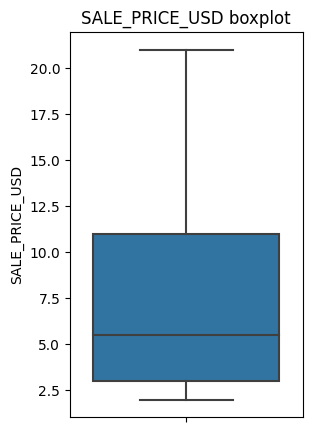

In [456]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['SALE_PRICE_USD'])
plt.title('SALE_PRICE_USD boxplot')
plt.show()

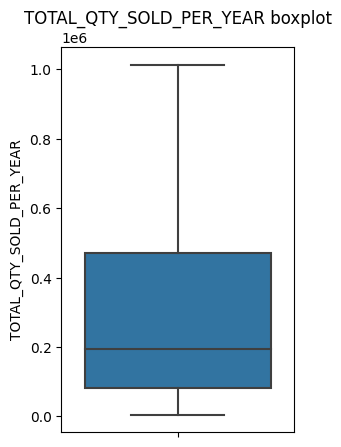

In [457]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD_PER_YEAR'])
plt.title('TOTAL_QTY_SOLD_PER_YEAR boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# View Target Column Range

In [458]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].min()
max_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 5211 - 1013940


# Train Test Split

In [459]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD_PER_YEAR', axis=1), final_df['TOTAL_QTY_SOLD_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((229, 10), (99, 10))

# Categorical Variable Encoding 

In [460]:
# Specify the columns to encode
columns_to_encode = ["MENU_TYPE", "ITEM_CATEGORY"]

ohe_enc = OneHotEncoder(variables=columns_to_encode, drop_last=True)

In [461]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode
ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True, variables=['MENU_TYPE', 'ITEM_CATEGORY'])

In [462]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [463]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [464]:
# Save the model to a file
joblib.dump(scaler, "C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_min_max_scaler.joblib")

['C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_min_max_scaler.joblib']

## Standard Scaler

In [465]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [466]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [467]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Models

## Linear Regression

In [468]:
# create the linear regression model
# fit the model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [469]:
# Calculated the fitted values for training set
y_fitted = lm.predict(X_train)

# Task 5a: calculated the predicated value for testing data
y_pred = lm.predict(X_test)

In [470]:
model_performance(lm)

the training root mean squared error is:  323818891.8470172
the testing root mean squared error is:  323906990.21193296

the training mean squared error is:  1.0485867471703022e+17
the testing mean squared error is:  1.0491573830815322e+17

training accuracy is:  -1036879.3099519929
testing accuracy is:  -1084446.6315793777


## Decision Tree

In [471]:
# Create Decision Tree Regressor with random state equal to 2
# fit the model to the training data
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [472]:
model_performance(tree_reg)

the training root mean squared error is:  424111.86399201246
the testing root mean squared error is:  384753.89341422403

the training mean squared error is:  179870873178.77927
the testing mean squared error is:  148035558497.40405

training accuracy is:  -0.7786279221652017
testing accuracy is:  -0.5301499411891819


## MLP Regressor

In [473]:
# Create the ann model
mlp = MLPRegressor(activation ='relu', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)
# Fit the model to the training set
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000, random_state=2,
             solver='sgd')

In [474]:
model_performance(mlp)

the training root mean squared error is:  6142549992676.496
the testing root mean squared error is:  6142549938539.126

the training mean squared error is:  3.7730920412530025e+25
the testing mean squared error is:  3.7730919747447025e+25

training accuracy is:  -373096918854764.8
testing accuracy is:  -390000654022473.1


## ADA Boost Regressor

In [475]:
# Build Ada Boost Model 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators = 20, learning_rate =0.1)
# fit the model to the training data
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=20)

In [476]:
model_performance(ada_reg)

the training root mean squared error is:  390151.49258587096
the testing root mean squared error is:  354750.32295323425

the training mean squared error is:  152218187166.98294
the testing mean squared error is:  125847791635.42398

training accuracy is:  -0.505188211809414
testing accuracy is:  -0.3008090280762461


## SVR

In [477]:
svr = SVR(C=0.8, kernel ='rbf')
svr.fit(X_train, y_train)

SVR(C=0.8)

In [478]:
model_performance(svr)

the training root mean squared error is:  343012.1634111573
the testing root mean squared error is:  319820.10610581917

the training mean squared error is:  117657344248.0025
the testing mean squared error is:  102284900269.53745

training accuracy is:  -0.16343815999215128
testing accuracy is:  -0.05725432268165931


## XGBoost Regressor

In [479]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  74067.87092797786
the testing root mean squared error is:  80073.27197659234

the training mean squared error is:  5486049503.803587
the testing mean squared error is:  6411728885.037329

training accuracy is:  0.9457519683014649
testing accuracy is:  0.9337260136960074


In [480]:
# Get the feature importances
feature_importance = xgb.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                     Feature  Importance
2             SALE_PRICE_USD    0.715124
3                       YEAR    0.092378
22    ITEM_CATEGORY_Beverage    0.041925
0               MENU_ITEM_ID    0.038212
16           MENU_TYPE_Ramen    0.028256
10         MENU_TYPE_Chinese    0.021146
15      MENU_TYPE_Vegetarian    0.016171
13           MENU_TYPE_Gyros    0.014406
4                 DAIRY_FREE    0.007171
17          MENU_TYPE_Crepes    0.006267
20  MENU_TYPE_Grilled Cheese    0.005895
8        MENU_TYPE_Ethiopian    0.005062
12        MENU_TYPE_Hot Dogs    0.003411
1           ITEM_SUBCATEGORY    0.002815
24        ITEM_CATEGORY_Main    0.000977
14           MENU_TYPE_Tacos    0.000518
11             MENU_TYPE_BBQ    0.000267
9        MENU_TYPE_Ice Cream    0.000000
7                   NUT_FREE    0.000000
18         MENU_TYPE_Poutine    0.000000
19      MENU_TYPE_Sandwiches    0.000000
6                    HEALTHY    0.000000
21    MENU_TYPE_Mac & Cheese    0.000000
5               

In [481]:
# Get the column names with importance score not equal to 0
selected_features = feature_importance_df[feature_importance_df['Importance'] != 0]['Feature'].tolist()

# Update the X_train_scaled and X_test_scaled with the selected features
X_train_scaled = X_train_scaled[selected_features]
X_test_scaled = X_test_scaled[selected_features]

In [492]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  74067.87092797786
the testing root mean squared error is:  79927.12745700512

the training mean squared error is:  5486049503.803587
the testing mean squared error is:  6388345703.528341

training accuracy is:  0.9457519683014649
testing accuracy is:  0.9339677108542711


In [482]:
# Build XGBoost Model
xgb_updated = XGBRegressor(n_estimators=32, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')

# Fit the model to the updated training data
xgb_updated.fit(X_train_scaled, y_train)

# Evaluate the performance of the updated model
model_performance(xgb_updated)

the training root mean squared error is:  30139.554097663462
the testing root mean squared error is:  52521.010616778076

the training mean squared error is:  908392721.2059824
the testing mean squared error is:  2758456556.2077155

training accuracy is:  0.9910174858793135
testing accuracy is:  0.9714875791999111


In [483]:
# Save the model to a file
joblib.dump(xgb_updated, "C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_xgb_model.joblib")

['C:/Users/donsu/OneDrive - Ngee Ann Polytechnic/ICP - Industry Currency Project/Week 3/Tasty_Insights/StreamlitApp/assets/models/product_qty_year_xgb_model.joblib']

# Model Improvement (GridSearch CV)

In [484]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50],
              'learning_rate': [0.1, 0.2, 0.3]}

xgb_grid = GridSearchCV(xgb_updated, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.3, 'n_estimators': 50}
Best score found:  0.942766795790569


# Improved Model 

In [485]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  2380.5336741531287
the testing root mean squared error is:  44268.650530806335

the training mean squared error is:  5666940.573776995
the testing mean squared error is:  1959713419.81866

training accuracy is:  0.9999439632523063
testing accuracy is:  0.9797436818253652


# Cross Validation

In [486]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

In [487]:
# Evaluate the Model using K-folds Cross validation
results  = cross_validate(xgb_updated, X_combined, y_combined, scoring='neg_mean_squared_error', cv=5, return_train_score = True)

# Convert the negative mean squared errors to positive RMSE values
train_rmse_scores = np.sqrt(-results['train_score'])
test_rmse_scores = np.sqrt(-results['test_score'])

# Print the RMSE scores for each fold
print('Train RMSE Scores:', train_rmse_scores)
print('Test RMSE Scores:', test_rmse_scores)

Train RMSE Scores: [29431.2657263  28956.54795533 28659.98126269 31330.58924748
 30854.78781542]
Test RMSE Scores: [45913.39497418 49825.38718229 84163.44985474 67865.23346211
 51759.65012862]


In [488]:
# Evaluate the Model using K-folds Cross validation
results  = cross_validate(xgb_improved, X_combined, y_combined, scoring='neg_mean_squared_error', cv=5, return_train_score = True)

# Convert the negative mean squared errors to positive RMSE values
train_rmse_scores = np.sqrt(-results['train_score'])
test_rmse_scores = np.sqrt(-results['test_score'])

# Print the RMSE scores for each fold
print('Train RMSE Scores:', train_rmse_scores)
print('Test RMSE Scores:', test_rmse_scores)

Train RMSE Scores: [2523.1632457  1546.17664159 1932.67444126 2458.53176963 1661.37893997]
Test RMSE Scores: [33948.96073916 32446.47318183 60531.66939462 41247.97170905
 31061.88568248]


# Feature Importance

In [489]:
# Get the feature importances
feature_importance = xgb_updated.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                     Feature  Importance
0             SALE_PRICE_USD    0.543579
1                       YEAR    0.133174
2     ITEM_CATEGORY_Beverage    0.074403
3               MENU_ITEM_ID    0.057402
4            MENU_TYPE_Ramen    0.046283
5          MENU_TYPE_Chinese    0.036876
7            MENU_TYPE_Gyros    0.025607
6       MENU_TYPE_Vegetarian    0.024681
14        ITEM_CATEGORY_Main    0.019142
10  MENU_TYPE_Grilled Cheese    0.009292
8                 DAIRY_FREE    0.008711
11       MENU_TYPE_Ethiopian    0.007939
13          ITEM_SUBCATEGORY    0.006155
9           MENU_TYPE_Crepes    0.002514
12        MENU_TYPE_Hot Dogs    0.002466
15           MENU_TYPE_Tacos    0.001192
16             MENU_TYPE_BBQ    0.000582


# Insights for Streamlit Data Pre-Processing

In [490]:
X_train_scaled.head()

,SALE_PRICE_USD,YEAR,ITEM_CATEGORY_Beverage,MENU_ITEM_ID,MENU_TYPE_Ramen,MENU_TYPE_Chinese,MENU_TYPE_Vegetarian,MENU_TYPE_Gyros,DAIRY_FREE,MENU_TYPE_Crepes,MENU_TYPE_Grilled Cheese,MENU_TYPE_Ethiopian,MENU_TYPE_Hot Dogs,ITEM_SUBCATEGORY,ITEM_CATEGORY_Main,MENU_TYPE_Tacos,MENU_TYPE_BBQ
0,0.052632,1.000000,1.0,0.582192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.105263,0.333333,0.0,0.047945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.578947,1.000000,0.0,0.828767,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.052632,0.000000,1.0,0.034247,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.789474,0.666667,0.0,0.082192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [491]:
X_train_scaled.columns

Index(['SALE_PRICE_USD', 'YEAR', 'ITEM_CATEGORY_Beverage', 'MENU_ITEM_ID',
       'MENU_TYPE_Ramen', 'MENU_TYPE_Chinese', 'MENU_TYPE_Vegetarian',
       'MENU_TYPE_Gyros', 'DAIRY_FREE', 'MENU_TYPE_Crepes',
       'MENU_TYPE_Grilled Cheese', 'MENU_TYPE_Ethiopian', 'MENU_TYPE_Hot Dogs',
       'ITEM_SUBCATEGORY', 'ITEM_CATEGORY_Main', 'MENU_TYPE_Tacos',
       'MENU_TYPE_BBQ'],
      dtype='object')